In [3]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy.linalg import hankel
from utils import params
import pandas as pd

In [4]:
with open('Results/final_output.pkl', 'rb') as f:
    results = pickle.load(f)
X_ori = results['x'].cpu().detach().numpy()
dx_ori = results['dx'].cpu().detach().numpy()
z = results['z'].cpu().detach().numpy()
sindy_coeff = results['sindy_coefficients'].cpu().detach().numpy()
Theta = results['Theta'].cpu().detach().numpy()

measured_index = [i*params['embedding_dimension'] for i in range(params['partial_measurement'])]
X_ori = X_ori[:, measured_index]
dx_ori = dx_ori[:, measured_index]

In [5]:
z

array([[ 6.98488  ,  5.7216663,  4.6786866, ...,  2.3559794,  1.408962 ,
        -2.3384657],
       [ 6.5436425,  5.6037855,  4.6487503, ...,  2.8638594,  1.2804823,
        -2.2958055],
       [ 6.6443553,  5.5049615,  4.4511223, ...,  2.758919 ,  1.4476006,
        -1.9468951],
       ...,
       [ 2.6625261,  2.3838289,  2.3424315, ...,  1.8238571,  1.1780457,
        -1.0721344],
       [ 2.6172724,  2.3228376,  2.3035762, ...,  1.5898362,  1.4109197,
        -1.7485203],
       [ 2.6646895,  2.3584018,  2.4432843, ...,  1.1686083,  1.5552701,
        -1.5349187]], dtype=float32)

In [6]:
z.shape

(401, 10)

In [7]:
from sindy_utils import sindy_library
from scipy.optimize import approx_fprime
def f(x):
    x = x.reshape(1,-1)
    Theta_curr = sindy_library(x,2,False)
    dz = np.matmul(Theta_curr, sindy_coeff)
    return dz.T.reshape(-1)

In [8]:
eig_all = np.zeros([z.shape[1], z.shape[0]])
for i in range(z.shape[0]):
    z_curr = z[i,:]
    J = approx_fprime(z_curr, f, epsilon=1e-6)
    eig, _ = np.linalg.eig(J)
    eig = np.real(eig)
    eig_all[:,i] = eig

In [9]:
eig_all

array([[ 1.55351915e-02,  1.05025194e-02,  1.87143509e-02, ...,
        -3.03712470e-03, -5.28280736e-03, -1.48036913e-02],
       [ 1.55351915e-02,  1.05025194e-02,  1.87143509e-02, ...,
        -3.03712470e-03, -5.28280736e-03, -1.48036913e-02],
       [-3.42501955e-05, -8.87863692e-03, -1.02511119e-02, ...,
        -2.15606729e-02, -2.74612578e-02, -1.40894039e-02],
       ...,
       [-1.39331416e-02, -8.31158144e-04, -8.93063936e-04, ...,
        -2.48396517e-02, -2.73881496e-02,  2.08140521e-02],
       [ 2.09544644e-03,  4.38816346e-03,  8.19306615e-03, ...,
         1.80958341e-02,  4.44464400e-02, -2.65085106e-02],
       [ 2.09544644e-03,  4.38816346e-03,  8.19306615e-03, ...,
         5.23894825e-02,  2.52872081e-02, -3.95827864e-02]])

In [10]:
negative_columns = np.where(np.all(eig_all < 0, axis=0))[0]

In [12]:
max_values = np.max(eig_all, axis=0)
min_values = np.min(eig_all, axis=0)

# Create a new NumPy array with max and min values
eig_all_bound = np.vstack((max_values, min_values))

In [13]:
eig_all_bound

array([[ 0.03344813,  0.01372249,  0.01871435,  0.04875853,  0.03552592,
         0.02007736,  0.01314189,  0.02633435,  0.02583253,  0.03001977,
         0.02005512,  0.02773221,  0.03466478,  0.03373795,  0.04715695,
         0.03188385,  0.03573531,  0.03998077,  0.03926546,  0.03721969,
         0.03351703,  0.02518175,  0.01684498,  0.03999327,  0.03302565,
         0.0373944 ,  0.0399091 ,  0.04359618,  0.07538582,  0.06394881,
         0.0590689 ,  0.04394349,  0.04028108,  0.04206481,  0.0300167 ,
         0.02632376,  0.02875262,  0.02760008,  0.01703028,  0.03201757,
         0.03210339,  0.03331247,  0.03530836,  0.03663384,  0.02843399,
         0.02500066,  0.02081067,  0.01910189,  0.01547954,  0.01731009,
         0.02581271,  0.03539275,  0.05155087,  0.01097657,  0.02189738,
         0.02183641,  0.03699122,  0.01196717,  0.01686032,  0.01795803,
         0.02175074,  0.01433765,  0.02790658,  0.02235823,  0.021442  ,
         0.0286031 ,  0.02971733,  0.02772142,  0.0

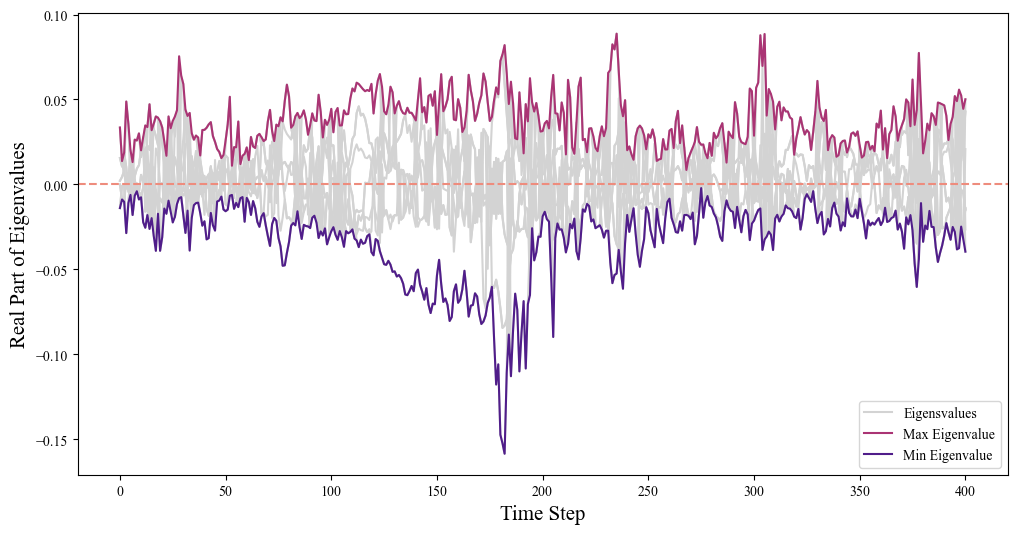

In [22]:
fig = plt.figure(figsize=(12, 6))

for i, row in enumerate(eig_all):
    if i == 0:
        plt.plot(row, "-", color='lightgrey', label= "Eigensvalues")
    else:
        plt.plot(row, "-", color='lightgrey')


plt.plot(eig_all_bound[0,:], "-", color='#aa3474', label= "Max Eigenvalue")
plt.plot(eig_all_bound[1,:], "-", color='#501d8a', label= "Min Eigenvalue")

plt.axhline(0, color='#ee8c7d', linestyle='--')
plt.xlabel('Time Step', fontsize=15)
plt.ylabel('Real Part of Eigenvalues', fontsize=15)
plt.legend(fontsize=10, loc="lower right")
plt.rcParams['font.family'] = 'Times New Roman'
plt.savefig("Figures/EigenValues.png",dpi=300)

In [26]:
z_re = z*100

In [27]:
z_re = z_re.T[0:6,:]

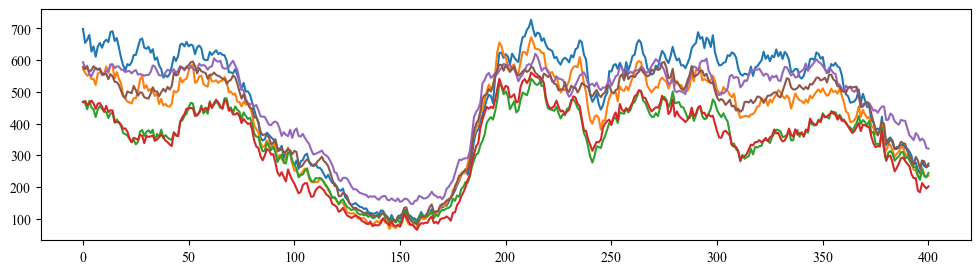

In [28]:
fig = plt.figure(figsize=(12, 3))
for i, row in enumerate(z_re):
    plt.plot(row, "-", label=f"Eigenvalue # {i+1}")

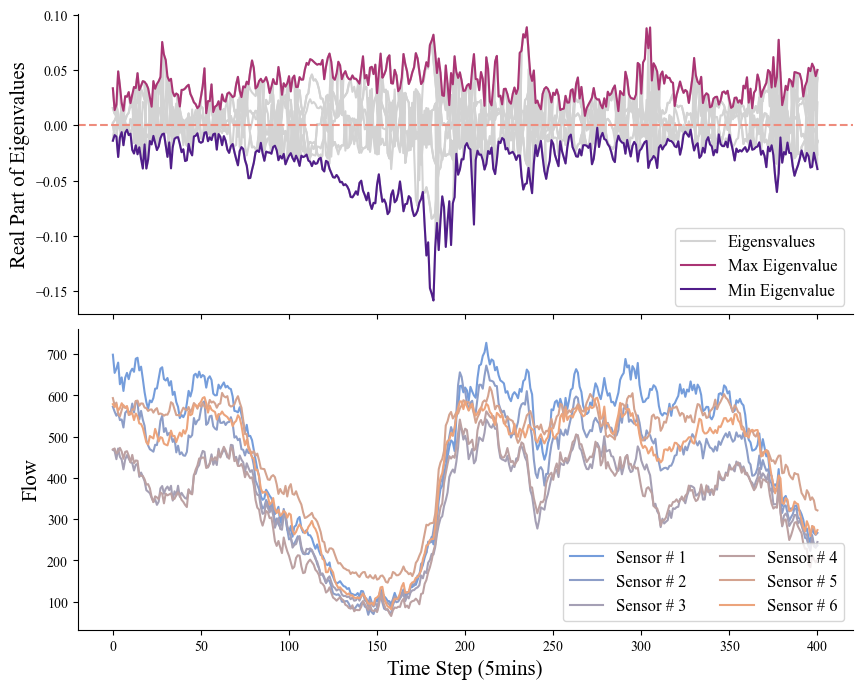

In [32]:
import matplotlib.colors as mcolors
x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.exp(x)

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

# Plot the first subplot

for i, row in enumerate(eig_all):
    if i == 0:
        ax1.plot(row, "-", color='lightgrey', label= "Eigensvalues")
    else:
        ax1.plot(row, "-", color='lightgrey')
ax1.plot(eig_all_bound[0,:], "-", color='#aa3474', label= "Max Eigenvalue")
ax1.plot(eig_all_bound[1,:], "-", color='#501d8a', label= "Min Eigenvalue")

ax1.axhline(0, color='#ee8c7d', linestyle='--')
#ax1.xlabel('Time Step', fontsize=15)
ax1.set_ylabel('Real Part of Eigenvalues', fontsize=15)
ax1.legend(fontsize=12, loc="lower right")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

start_color = '#759DDB'
end_color = '#ECA47C'

cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_cmap', [start_color, end_color], N=z_re.shape[0])
# Plot the second subplot
for i, row in enumerate(z_re):
    ax2.plot(row, "-", color = cmap(i), label=f"Sensor # {i+1}")
ax2.legend(fontsize=12, loc="lower right", ncol=2)
ax2.set_ylabel('Flow', fontsize=15)
ax2.set_xlabel('Time Step (5mins)', fontsize=15)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
# Set a shared x-axis label

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.05)
# Show the plot
plt.show()
fig.savefig("Figures/EigenValues_alt.png",dpi=300)